In [8]:
import os
import sys

# Add the project root to the system path

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Navigate to the project root (adjust number of ".." as needed)
project_root = os.path.abspath(os.path.join(notebook_dir, "../"))
print(project_root)

# Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.figures import *
import pandas as pd

/Users/annaboser/Documents/GitHub/smallholder-irrigation-dataset


In [5]:
# Specify whose data to QC
operator_initials = "DSB"

In [9]:
# Read in and merge all data in the merged folder
merged_folder = "../data/labels/labeled_surveys/random_sample/merged"
files = os.listdir(merged_folder)

# Assuming the files are CSVs, read and merge them into a single DataFrame
df = pd.concat([pd.read_csv(os.path.join(merged_folder, file)) for file in files if file.endswith('.csv')], ignore_index=True)
df

,site_id,internal_id,plot_file,operator,operator_initials,x,y,water_source,image_number,year,month,day,irrigation,percent_coverage,percent_coverage_high_certainty,poly_avg_size,poly_avg_size_high_certainty,source_file
0,id_5170792,8,Zambia_0.05_n_225-249.csv,NaN,DSB,23.460475,-15.076142,False,1,2019,7,10,1,0.000000,0.000000,NaN,NaN,DSB_225-249
1,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,1,2018,8,29,1,0.000000,0.000000,NaN,NaN,DSB_225-249
2,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,2,2018,8,26,1,0.000000,0.000000,NaN,NaN,DSB_225-249
3,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,3,2017,9,11,1,0.000000,0.000000,NaN,NaN,DSB_225-249
4,id_5154963,9,Zambia_0.05_n_225-249.csv,NaN,DSB,27.607460,-14.696160,False,4,2017,7,17,1,0.000000,0.000000,NaN,NaN,DSB_225-249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,id_1032067,25,Zambia_0.05_n_101-125.csv,NaN,MV,31.403282,-8.874727,True,1,2024,9,11,1,0.000000,0.000000,NaN,NaN,MV_JL_101-125
1481,id_5062566,21,Zambia_0.05_n_101-125.csv,NaN,MV,28.862556,-11.155457,False,1,2024,8,27,1,0.000000,0.000000,NaN,NaN,MV_JL_101-125
1482,id_5062566,21,Zambia_0.05_n_101-125.csv,NaN,MV,28.862556,-11.155457,False,2,2019,6,14,4,0.049521,0.049521,495.317096,495.317096,MV_JL_101-125
1483,id_5063118,20,Zambia_0.05_n_101-125.csv,NaN,MV,29.970006,-11.173630,False,1,2024,8,11,1,0.000000,0.000000,NaN,NaN,MV_JL_101-125


# Progress statistics

In [10]:
# Statistics

# How many unique surveys/locations/images have been labeled
# How many unique surveys/locations/images have I labeled (original and corrected labels)
# How many unique surveys/locations/images have I labeled that haven't been corrected by someone else
# How many unique surveys/locations/images have I corrected

def count_surveys_locations_images(df):

    surveys = df['source_file'].unique()
    locations = df['site_id'].unique()
    
    df['image_id'] = df['site_id'].astype(str) + '_' + df['image_number'].astype(str)
    images = df['image_id'].unique()

    return len(surveys), len(locations), len(images)


def summarize_operator_stats(df, operator_initials, with_irr_only="False"):

    # If you only care about labels with irrigation, remove the rest (3 and above)
    if with_irr_only == "True":
        # Remove labels with irrigation less than 3
        df = df[df['irrigation'] >= 3]

    # 1) Total counts across all labels
    total_surveys, total_locs, total_imgs = count_surveys_locations_images(df)
    
    # 2) Unique (most recent) labels: keep only those source_files with no later corrections
    all_sources = set(df['source_file'])
    unique_sources = {
        f for f in all_sources
        if not any((f in other and f != other) for other in all_sources)
    }
    unique_df = df[df['source_file'].isin(unique_sources)]
    unique_surveys, unique_locs, unique_imgs = count_surveys_locations_images(unique_df)
    
    # 3) All labels by this operator
    mine = df[df['operator_initials'] == operator_initials]
    my_surveys, my_locs, my_imgs = count_surveys_locations_images(mine)
    
    # 4) Labels by this operator that they corrected (someone else’s initials after theirs)
    my_corrected_labels = mine[mine["source_file"].str.split("_", expand=True)[1].str.isalpha()]
    corr_surveys, corr_locs, corr_imgs = count_surveys_locations_images(my_corrected_labels)
    
    # 5) Labels by this operator that have NOT been corrected by anyone else later
    #    (original & still final for that sample)
    other_sources = set(df[df["operator_initials"] != operator_initials]["source_file"])
    corrected = [f for f in set(mine["source_file"])
                 if any(f in o for o in other_sources)]
    my_uncorrected_labels = mine[~mine["source_file"].isin(corrected)] # ones others haven't had a look at after me
    my_uncorrected_labels = my_uncorrected_labels[~my_uncorrected_labels["source_file"].isin(my_corrected_labels["source_file"])]
    unc_surveys, unc_locs, unc_imgs = count_surveys_locations_images(my_uncorrected_labels)
    
    # 6) Build summary table
    summary = pd.DataFrame({
        'All':                                    [total_surveys, total_locs, total_imgs],
        'Unique (most recent)':                         [unique_surveys, unique_locs, unique_imgs],
        f'All {operator_initials}':               [my_surveys,    my_locs,    my_imgs],
        f'Corrected by {operator_initials}':      [corr_surveys,  corr_locs,  corr_imgs],
        f'{operator_initials} original uncorrected': [
            unc_surveys, unc_locs, unc_imgs
        ],
        f'{operator_initials} orig. corrected by others': [
            my_surveys - corr_surveys - unc_surveys,
            my_locs    - corr_locs    - unc_locs,
            my_imgs    - corr_imgs    - unc_imgs
        ],
        f'Frac {operator_initials} last-labeled': [
            (corr_surveys + unc_surveys) / unique_surveys,
            (corr_locs    + unc_locs)    / unique_locs,
            (corr_imgs    + unc_imgs)    / unique_imgs
        ],
        f'Frac of target {operator_initials} last': [
            (corr_surveys + unc_surveys) / 40,
            (corr_locs    + unc_locs)    / 1000,
            (corr_imgs    + unc_imgs)    / 3000
        ],
    }, index=['Surveys', 'Locations', 'Images'])
    
    return summary


In [11]:
summary_table = summarize_operator_stats(df, "AB")
print("Summary of all labels:")
summary_table

Summary of all labels:


/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_90853/3479624901.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_id'] = df['site_id'].astype(str) + '_' + df['image_number'].astype(str)
/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_90853/3479624901.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_id'] = df['site_id'].astype(str) + '_' + df['image_number'].astype(str)


,All,Unique (most recent),All AB,Corrected by AB,AB original uncorrected,AB orig. corrected by others,Frac AB last-labeled,Frac of target AB last
Surveys,27,20,1,1,0,0,0.050000,0.025
Locations,364,364,21,21,0,0,0.057692,0.021
Images,904,901,51,51,0,0,0.056604,0.017


In [12]:
summary_table = summarize_operator_stats(df, operator_initials, with_irr_only="True")
print("Summary of only irrigated labels:")
summary_table

Summary of only irrigated labels:


/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_86607/3479624901.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_id'] = df['site_id'].astype(str) + '_' + df['image_number'].astype(str)
/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_86607/3479624901.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_id'] = df['site_id'].astype(str) + '_' + df['image_number'].astype(str)
/var/folders/1f/_ptk0jz93h39qj25crwwtb0w0000gn/T/ipykernel_86607/3479624901.py:13: Setting

,All,Unique (most recent),All DSB,Corrected by DSB,DSB original uncorrected,DSB orig. corrected by others,Frac DSB last-labeled,Frac of target DSB last
Surveys,27,20,8,2,3,3,0.250000,0.125
Locations,151,138,72,17,26,29,0.311594,0.043
Images,320,292,134,22,59,53,0.277397,0.027


In [ ]:
# Compare average statistics across all operators

# Statsitics we are interested in: 
# - number of images labeled per survey (plot file)
# - fraction of locations found with any irrigation (cert 3 and up)
# - Irrigation certainty historgram by image
# 

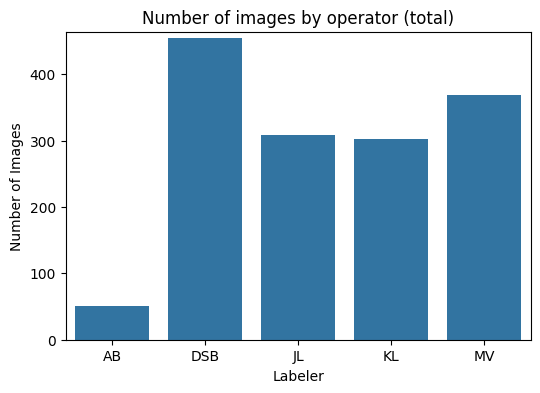

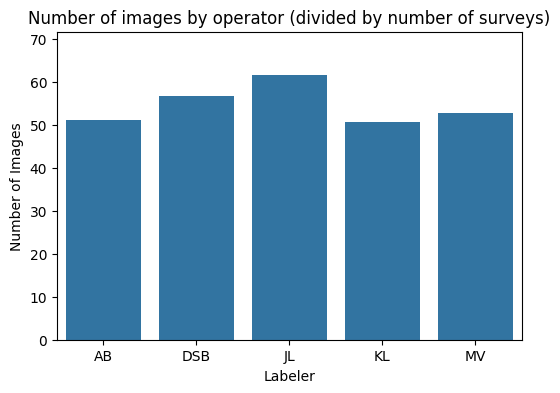

In [3]:
plot_num_images(df, title="Number of images by operator (total)")
plot_num_images(df, title="Number of images by operator (divided by number of surveys)", by_survey=True)

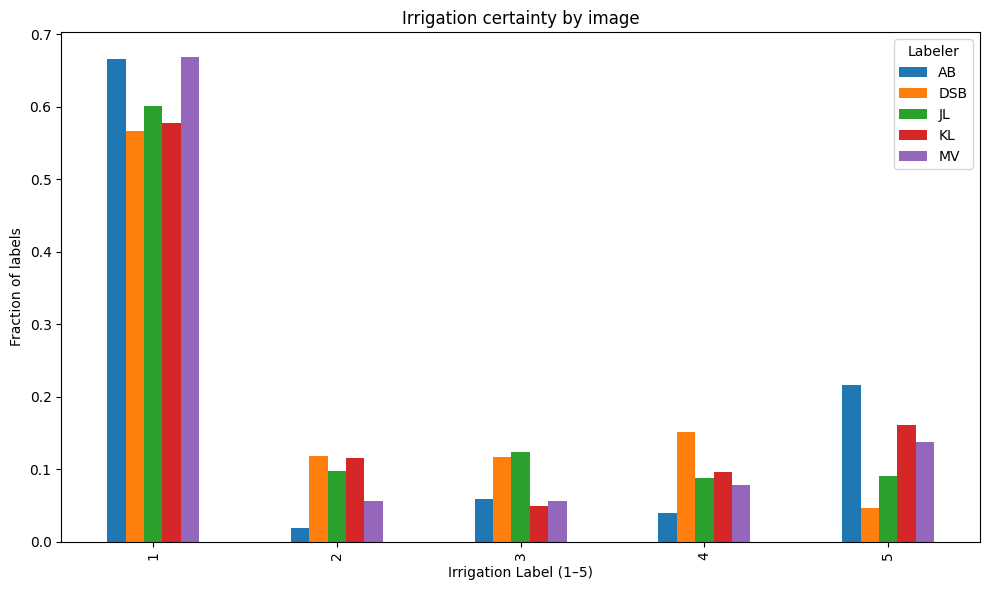

In [3]:
plot_irrigation_distribution(df, title="Irrigation certainty by image")

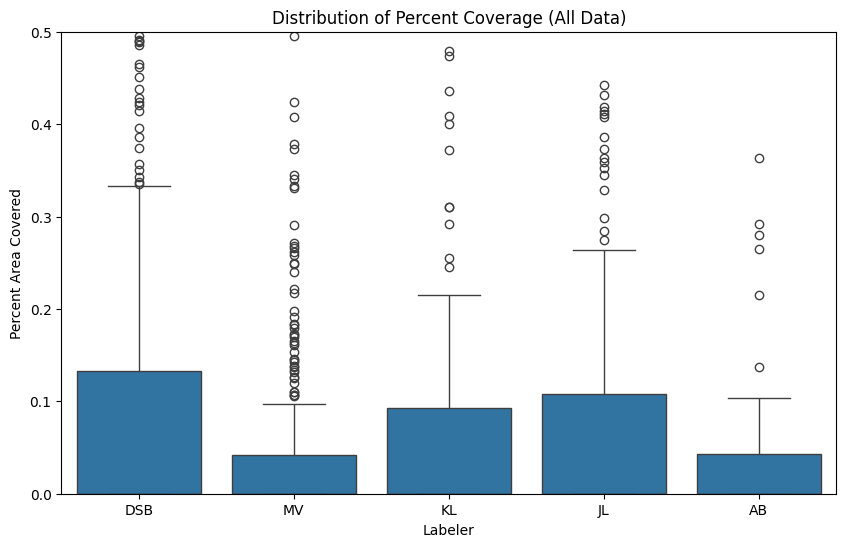

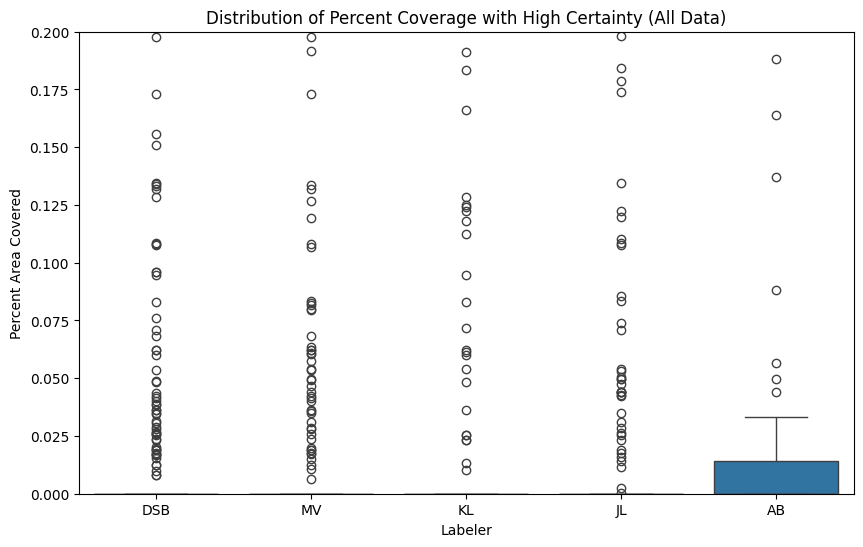

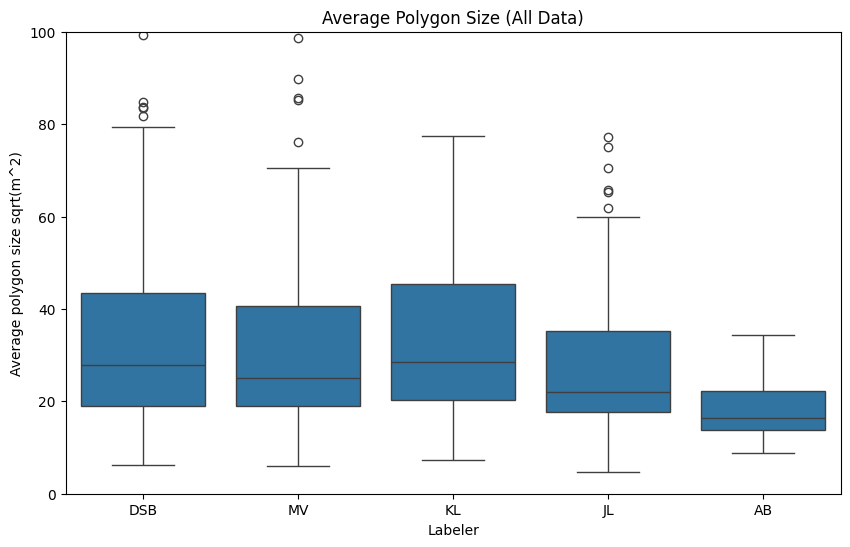

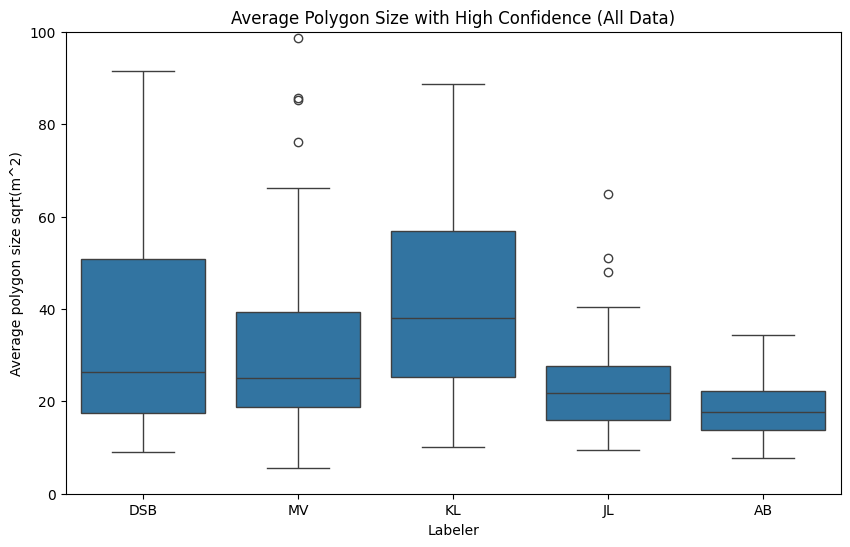

In [6]:
plot_percent_coverage(df, "Distribution of Percent Coverage (All Data)", certain_only=False, ymax=.5)
plot_percent_coverage(df, "Distribution of Percent Coverage with High Certainty (All Data)", certain_only=True, ymax=.2)
plot_avg_polygon_size(df, "Average Polygon Size (All Data)", certain_only=False, ymax=100)
plot_avg_polygon_size(df, "Average Polygon Size with High Confidence (All Data)", certain_only=True, ymax=100)